In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-03-30 02:11:55.721544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 02:11:55.721586: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_NMA.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_NMA.csv")
type1 = np.array(data1['ttype'])
type2 = np.array(data2['ttype'])
data1 = np.array(data1)
data2 = np.array(data2)
data1 = data1[:, 1:21]
data2 = data2[:, 1:21]

# Sampling
idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1,type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [4]:
# Vars
reduced_dim = 10

# ComManDo

In [5]:
cm = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500)
cm_data = cm.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.1162 alpha:0.5242
epoch:[1000/2000] err:0.1359 alpha:0.6158
epoch:[1500/2000] err:0.1478 alpha:0.6745
epoch:[2000/2000] err:0.1545 alpha:0.7120
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.166468
epoch:[1000/2000]: loss:0.987309
epoch:[1500/2000]: loss:0.984469
epoch:[2000/2000]: loss:0.966817
Finished Mapping!
Setup: 0.0025735960007295944
Get subset samples: 0.0015265248303947374
Run model: 0.001165071980994071
Reconstruction loss: 5.516706920025172e-05
Difference calculation: 0.00047175234209880727
Aligned loss: 3.898762660974171e-05
F-cross loss: 1.2700644786491466e-05
F-inv-cross loss: 1.3413263995244051e-05
Step: 0.0025878364770114785
Output: 0.00253891600004863
Total: 0.010983966235869048
---------------------------------
ComManDo Do

In [6]:
# from sklearn.metrics import silhouette_score
# print([silhouette_score(cm_data[i], type1) for i in range(2)])

# UnionCom

In [7]:
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.1162 alpha:0.5242
epoch:[1000/2000] err:0.1359 alpha:0.6158
epoch:[1500/2000] err:0.1478 alpha:0.6745
epoch:[2000/2000] err:0.1545 alpha:0.7120
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:3.428136, align_loss:0.465268
epoch:[20/100]: loss:3.196833, align_loss:0.493003
epoch:[30/100]: loss:3.030924, align_loss:0.499849
epoch:[40/100]: loss:3.169136, align_loss:0.508586
epoch:[50/100]: loss:2.709020, align_loss:0.537016
epoch:[60/100]: loss:2.778569, align_loss:0.513209
epoch:[70/100]: loss:2.730824, align_loss:0.517029
epoch:[80/100]: loss:2.877424, align_loss:0.515495
epoch:[90/100]: loss:2.673460, align_loss:0.506657
epoch:[100/100]: loss:2.793488, align_loss:0.481850
Done
---------------------------------
ComManDo Done!
Dis

# Nonlinear Manifold Alignment

In [8]:
nl_data, _ = mmd_combine(data1, data2, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)

# Figure Generation

In [9]:
priors = np.zeros((len(dataset[0]), len(dataset[0])))
cm_data_none = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, P=priors).fit_transform(dataset=dataset)

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
priors = np.diag(priors)
cm_data_half = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, P=priors).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.1162 alpha:0.5242
epoch:[1000/2000] err:0.1359 alpha:0.6158
epoch:[1500/2000] err:0.1478 alpha:0.6745
epoch:[2000/2000] err:0.1545 alpha:0.7120
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.156686
epoch:[1000/2000]: loss:0.986537
epoch:[1500/2000]: loss:0.974610
epoch:[2000/2000]: loss:0.975692
Finished Mapping!
Setup: 0.0025356360001751455
Get subset samples: 0.0016354243212068468
Run model: 0.0012248018974967635
Reconstruction loss: 5.8294398100952094e-05
Difference calculation: 0.0005314976383966496
F-cross loss: 3.80991962936605e-05
F-inv-cross loss: 1.445730310115323e-05
Step: 0.0027116993449790242
Output: 0.0030638859989267075
Total: 0.011813796098676903
---------------------------------
ComManDo Done!
Distance: 0.1894351729988557
Cor

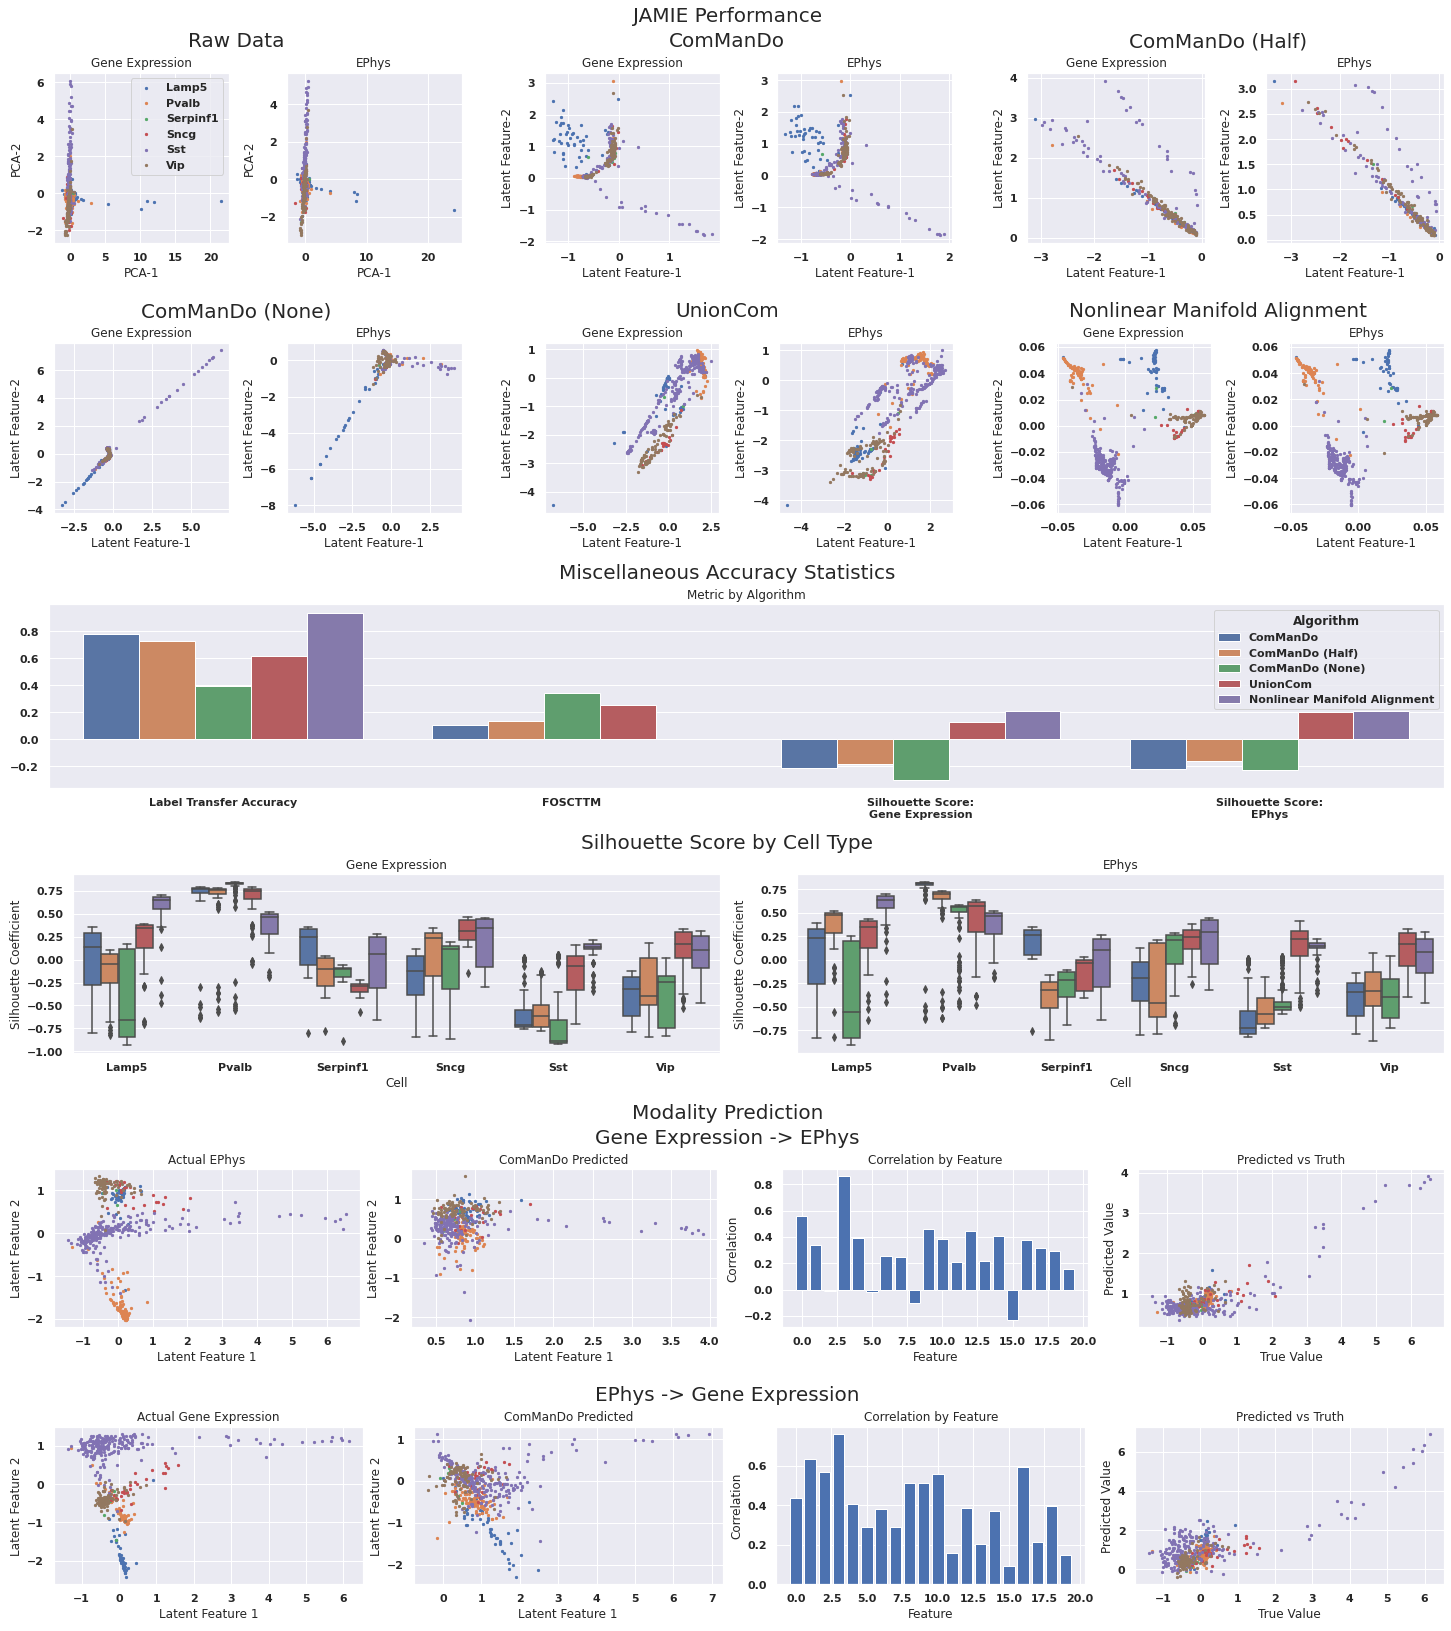

In [14]:
#%%capture --no-display
params = {
    'dataset_names': ['Gene Expression', 'EPhys'],
    'alg_results': [cm_data_half, cm_data_none, uc_data, nl_data],
    'alg_names': ['ComManDo (Half)', 'ComManDo (None)', 'UnionCom', 'Nonlinear Manifold Alignment'],
    'scale': 20,
    'reconstruction_features': {(0, 1): [3, 0], (1, 0): [3, 1]},
    # 'integrated_use_pca': True,
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, cm_data, dataset, labels, **params)